# Tutorial 0 - Particle sizing

Welcome to this first tutorial. In this notebook, we will delve into one of the simplest yet insightful applications of Differential Dynamic Microscopy: particle sizing. **FastDDM**, a robust and efficient Python package, will assist us throughout this exploration.

Whether you're a seasoned researcher in the field of soft matter physics or a curious enthusiast, this notebook aims to provide a hands-on experience in leveraging Differential Dynamic Microscopy, with the help of **fastDDM**, to uncover the hidden dynamics within colloidal systems.

### Purpose

The aim of this notebook is to:

1. provide the basic instruction on how to work with fastDDM
2. illustrate how to obtain a structure function from an image sequence and navigate its properties
3. calculate the azimuthal average of the structure function
4. fit the azimuthal average to gain information on the sample's dynamics
5. convert the dynamical properties into particle size

## Setting up your workspace

We assume you have already installed fastDDM on your machine. Also, you have installed the packages required for scientific analysis, fitting, and visualization (see main README).

For this tutorial, we will need the open-source microscopy videos kindly provided by [Bradley et al](https://datashare.ed.ac.uk/handle/10283/4858). Download all files and place the folder in the directory containing this notebook.

## Samples description

(PUT HERE DESCRIPTION FROM THE PAPER.)

## Fasten your seatbelts!

Let's start working with our images. We begin by importing the libraries we need.

In [1]:
%matplotlib notebook

import gc
import os
import lmfit
import numpy as np

# matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.lines import Line2D
from matplotlib.offsetbox import AnchoredText

def color_space( 
    length: int,
    colormap: cm.colors.LinearSegmentedColormap = cm.viridis,
    vmin: float = 0.2, 
    vmax: float = 1.0
) -> np.ndarray:
    return colormap(np.linspace(vmin, vmax, length))

# fastddm
import fastddm as fddm
from fastddm.fit import fit

Here we define the paths to the videos and the labels indicating the nominal particle size.

In [2]:
# directory containing the videos
main_directory = 'Video_dataset/Video_dataset/third_vid_dataset/27_07_2021_BF_Scaling_Neat/'

# file names (including enclosing folder)
file_names = [
    'BF20x_1x1_200fps_Pos3_3/BF20x_1x1_200fps_Pos3_3_MMStack_Default.ome.tif',
    'BF20x_1x1_200fps_Pos1_3/BF20x_1x1_200fps_Pos1_3_MMStack_Default.ome.tif',
    'BF20x_1x1_200fps_Pos4_3/BF20x_1x1_200fps_Pos4_3_MMStack_Default.ome.tif',
    'BF20x_1x1_200fps_Pos0_3/BF20x_1x1_200fps_Pos0_3_MMStack_Default.ome.tif',
    'BF20x_1x1_200fps_Pos5_3/BF20x_1x1_200fps_Pos5_3_MMStack_Default.ome.tif',
    'BF20x_1x1_200fps_Pos2_3/BF20x_1x1_200fps_Pos2_3_MMStack_Default.ome.tif',
]

# create full paths
file_paths = [os.path.join(main_directory, fn) for fn in file_names]

# list of labels
labels = [
    '60 nm',
    '120 nm',
    '240 nm',
    '500 nm',
    '1100 nm',
    '2100 nm',
]

The experimental parameters are listed in Sec. 4 of the reference [paper](https://pubs.rsc.org/en/content/articlepdf/2023/sm/d3sm00593c).
Videos are acquired at 200 fps with a Hamamatsu Orca Flash 4.0 camera (pixel size 6.5 $\mu$m) using a 20$\times$, NA 0.5 objective. This gives an effective pixel size of $\delta_{px} = 6.5/20 \, {\mu\mathrm{m}} = 325 \, \mathrm{nm}$.

In [3]:
# experimental parameters
frame_rate = 200       # frames per second
pixel_size = 6.5/20    # microns per pixel

It's always useful start by inspecting the videos. We load the first frame from every movie and display the images in a grid.

<IPython.core.display.Javascript object>


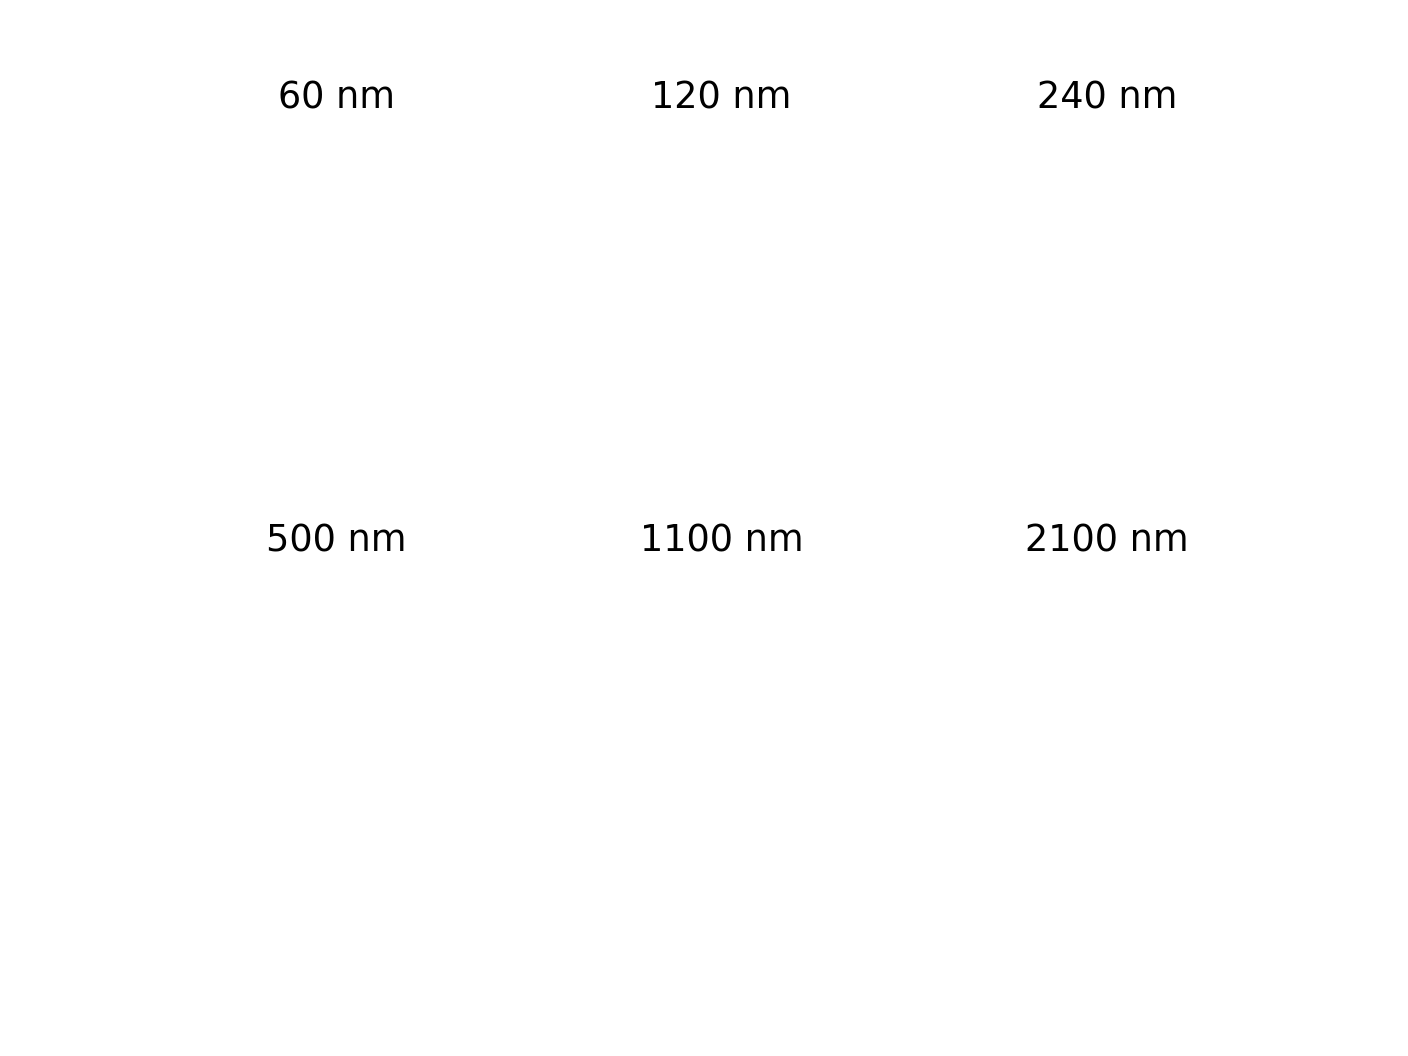

In [4]:
fig = plt.figure()
fig.tight_layout()
gs = fig.add_gridspec(ncols=3, nrows=2)
axs = gs.subplots()

for n, ax in enumerate(axs.flatten()):
    # load image
    #img = fddm.read_images(paths[n], [0])
    #img = img[0]    # `read_images` returns a 3d numpy array
    
    #ax.imshow(img, cmap='gray')
    
    ax.set_axis_off()
    ax.set_title(labels[n])

### Structure function

We now dive into the fascinating realm of Differential Dynamic Microscopy (DDM). The structure function is a fundamental tool for unraveling spatial correlations and dynamic features within images.

The procedure is the following:

#### Data preparation
We start by loading the image sequence from the file. To compute the structure function, fastDDM requires a 3D numpy array as an input. The time runs over the first axis, while y and x run over the last two.

#### Structure function calculation
DDM is applied to the image sequence to obtain the structure function. To inform the object of the experimental parameters, we pass the frame rate and the pixel size. These will update the time delays $\Delta t$ and the wave vectors $k$ (remember that these quantities have units!).

#### Azimuthal average calculation
For isotropic systems, we can improve the statistics by averaging the structure function over annuli at constant $k$.